Copyright (c) MONAI Consortium
Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at
&nbsp;&nbsp;&nbsp;&nbsp;http://www.apache.org/licenses/LICENSE-2.0
Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

# Ajuste Fino del Modelo VISTA3D para la Canalización de Hugging Face

Este tutorial ilustrará cómo realizar un ajuste fino de un modelo VISTA3D utilizando el conjunto de datos de bazo de Decathlon e integrarlo en una canalización existente de VISTA3D en Hugging Face.

El conjunto de datos del Bazo se puede descargar desde http://medicaldecathlon.com/.


Objetivo: Bazo
Modalidad: TC
Tamaño: 61 volúmenes 3D (41 de Entrenamiento + 20 de Prueba)
Fuente: Memorial Sloan Kettering Cancer Center
Desafío: Gran variabilidad en el tamaño del objeto de interés

Esta celda introductoria presenta el objetivo del tutorial: ajustar un modelo VISTA3D preentrenado con datos específicos de segmentación de bazo y luego usar ese modelo ajustado dentro de una canalización de Hugging Face. También proporciona detalles sobre el conjunto de datos que se utilizará.

## Configurar el entorno

Esta celda se asegura de que las bibliotecas necesarias, `monai` y `matplotlib`, estén instaladas en el entorno. `monai-weekly` se instala con dependencias adicionales para el manejo de datos (`gdown`, `nibabel`), barras de progreso (`tqdm`) y el motor de entrenamiento (`ignite`).

In [1]:
!python -c "import monai" || pip install -q "monai-weekly[gdown, nibabel, tqdm, ignite]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

## Configurar importaciones

Aquí se importan todos los módulos y funciones necesarios de bibliotecas como `monai`, `torch`, `matplotlib` y `huggingface_hub`. Estas importaciones son esenciales para la carga de datos, transformaciones, construcción de modelos, entrenamiento y visualización.

In [2]:
from monai.transforms import (
    LoadImage,
    ToNumpy,
)
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob
import numpy as np
from huggingface_hub import snapshot_download

print_config()

MONAI version: 1.5.0
Numpy version: 2.3.1
Pytorch version: 2.6.0+cu124
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: d388d1c6fec8cb3a0eebee5b5a0b9776ca59ca83
MONAI __file__: /home/<username>/Workspace/Medical-Image-PGTD/.venv/lib/python3.11/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.11
ITK version: 5.4.4
Nibabel version: 5.3.2
scikit-image version: 0.25.2
scipy version: 1.16.0
Pillow version: 11.3.0
Tensorboard version: 2.19.0
gdown version: 5.2.0
TorchVision version: 0.21.0+cu124
tqdm version: 4.67.1
lmdb version: 1.7.2
psutil version: 7.0.0
pandas version: 2.3.1
einops version: 0.8.1
transformers version: 4.53.2
mlflow version: 3.1.1
pynrrd version: 1.1.3
clearml version: 2.0.2

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Configurar el directorio de datos

Puede especificar un directorio con la variable de entorno `MONAI_DATA_DIRECTORY`.
Esto le permite guardar resultados y reutilizar descargas.
Si no se especifica, se utilizará un directorio temporal.

Esta sección configura un directorio para almacenar los datos. Usar una variable de entorno como `MONAI_DATA_DIRECTORY` permite la persistencia de los datos entre ejecuciones, mientras que un directorio temporal asegura que los datos se limpien después de la sesión si no se especifica una ruta.

In [3]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
if directory is not None:
    os.makedirs(directory, exist_ok=True)
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmpwnmq4x11


## Descargar el conjunto de datos

Descarga y extrae el conjunto de datos.
El conjunto de datos proviene de http://medicaldecathlon.com/.

Esta celda descarga y extrae el conjunto de datos de la Tarea 09 del Medical Segmentation Decathlon (Bazo). La función `download_and_extract` de MONAI gestiona este proceso, verificando la integridad del archivo con un hash MD5.

In [4]:
resource = "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task09_Spleen.tar"
md5 = "410d4a301da4e5b2f6f86ec3ddba524e"

compressed_file = os.path.join(root_dir, "Task09_Spleen.tar")
data_dir = os.path.join(root_dir, "Task09_Spleen")
if not os.path.exists(data_dir):
    download_and_extract(resource, compressed_file, root_dir, md5)

Task09_Spleen.tar: 1.50GB [19:22, 1.38MB/s]                               

2025-07-16 17:40:45,920 - INFO - Downloaded: /tmp/tmpwnmq4x11/Task09_Spleen.tar


2025-07-16 17:40:48,124 - INFO - Verified 'Task09_Spleen.tar', md5: 410d4a301da4e5b2f6f86ec3ddba524e.
2025-07-16 17:40:48,125 - INFO - Writing into directory: /tmp/tmpwnmq4x11.


## Establecer la ruta del conjunto de datos MSD Spleen

En esta celda, se preparan las rutas a los archivos de imagen y etiquetas. Luego, los datos se dividen en conjuntos de entrenamiento y validación. `data_dicts` es una lista de diccionarios, un formato común en MONAI para organizar los datos de entrada.

In [5]:
train_images = sorted(glob.glob(os.path.join(data_dir, "imagesTr", "*.nii.gz")))
train_labels = sorted(glob.glob(os.path.join(data_dir, "labelsTr", "*.nii.gz")))
data_dicts = [{"image": image_name, "label": label_name} for image_name, label_name in zip(train_images, train_labels)]
train_files, val_files = data_dicts[:-9], data_dicts[-9:]

## Descargar el pipeline de VISTA3D de Hugging Face

VISTA3D-HF es un modelo de ejemplo de código abierto para VISTA3D, disponible en el Hugging Face Hub para acceso público. Se puede descargar utilizando la API de Hugging Face.

Esta celda utiliza la función `snapshot_download` de la biblioteca `huggingface_hub` para descargar todos los archivos asociados con el repositorio del modelo VISTA3D-HF, incluyendo el código de la canalización, la configuración y los pesos del modelo preentrenado.

In [6]:
VISTA3D_HF_REPO = "MONAI/VISTA3D-HF"
snapshot_download(VISTA3D_HF_REPO, local_dir=".")

Fetching 18 files:   0%|          | 0/18 [00:00<?, ?it/s]

.gitattributes: 0.00B [00:00, ?B/s]

LICENSE: 0.00B [00:00, ?B/s]

.gitignore: 0.00B [00:00, ?B/s]

README.md: 0.00B [00:00, ?B/s]

data_license.txt:   0%|          | 0.00/232 [00:00<?, ?B/s]

hugging_face_pipeline.py: 0.00B [00:00, ?B/s]

metadata.json: 0.00B [00:00, ?B/s]

evaluator.py: 0.00B [00:00, ?B/s]

early_stop_score_function.py:   0%|          | 0.00/454 [00:00<?, ?B/s]

vista3d_model.py: 0.00B [00:00, ?B/s]

inferer.py: 0.00B [00:00, ?B/s]

vista3d_config.py:   0%|          | 0.00/601 [00:00<?, ?B/s]

vista3d_pipeline.py: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/872M [00:00<?, ?B/s]

trainer.py: 0.00B [00:00, ?B/s]

__init__.py:   0%|          | 0.00/821 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

'/home/emi/Workspace/Medical-Image-PGTD/notebooks'

## Definir funciones de utilidad

Esta celda define una función auxiliar, `convert_to_numpy`, que se utilizará más adelante para convertir las salidas del tensor de PyTorch a arrays de NumPy para su visualización con Matplotlib. También inicializa un cargador de imágenes de MONAI.

In [7]:
numpy_transform = ToNumpy()
loader = LoadImage()


def convert_to_numpy(input):
    numpy_output = numpy_transform(input)
    numpy_output = np.squeeze(numpy_output, axis=0)
    return numpy_output

## Inferencia en el conjunto de prueba con el modelo VISTA3D-HF

Dado que el modelo VISTA3D-HF es un modelo fundacional para imágenes médicas 3D, podemos ejecutar directamente este modelo en el conjunto de datos del bazo.

Aquí se demuestra la capacidad "zero-shot" del modelo VISTA3D. Se inicializa el pipeline de Hugging Face (`HuggingFacePipelineHelper`) con los pesos preentrenados y se ejecuta la inferencia en algunas imágenes de prueba del bazo. Los resultados se visualizan para mostrar el rendimiento del modelo base sin ningún ajuste fino.

Device set to use cuda:0


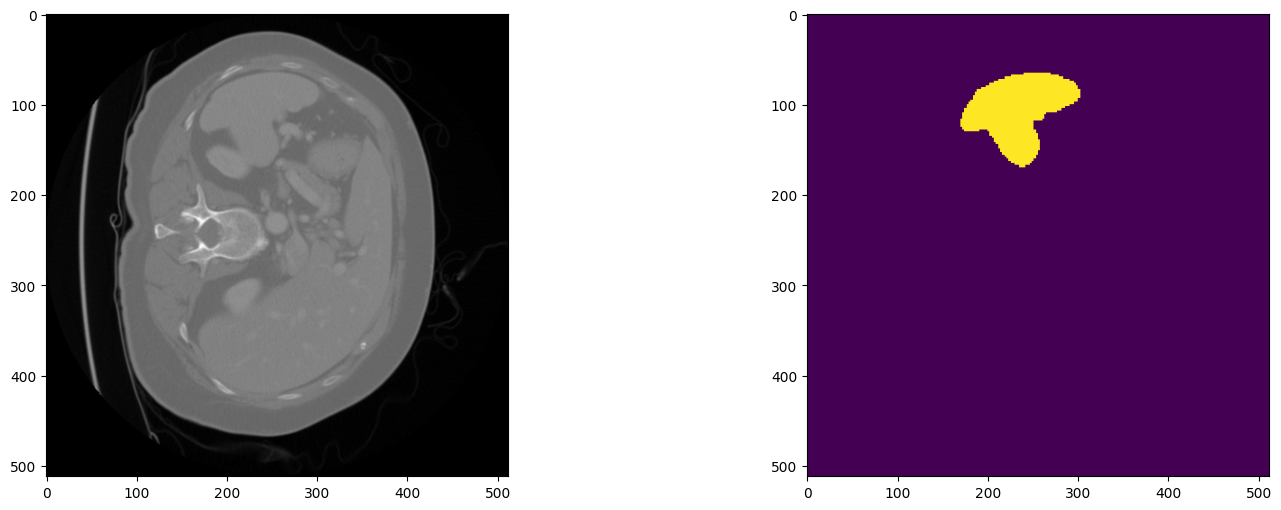

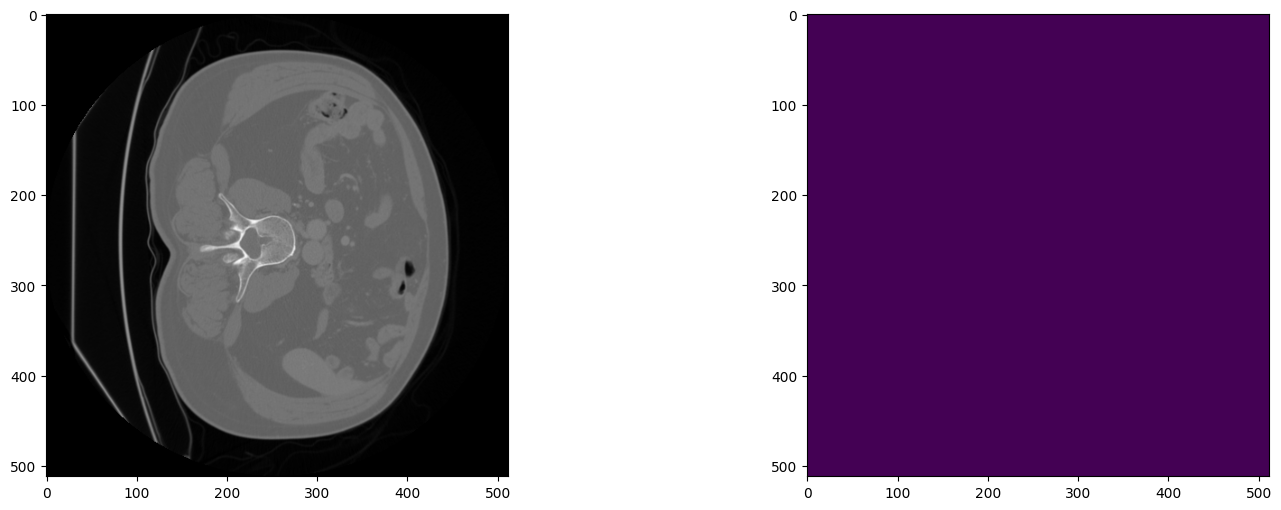

In [8]:
test_images = sorted(glob.glob(os.path.join(data_dir, "imagesTs", "*.nii.gz")))
test_data = [{"image": image, "label_prompt": [3]} for image in test_images]

# This is from the vista3d hugging face model. Can only be imported after downloading.
from hugging_face_pipeline import HuggingFacePipelineHelper  # noqa: E402

pipeline_helper = HuggingFacePipelineHelper("vista3d")
pipeline = pipeline_helper.init_pipeline("./vista3d_pretrained_model", device=torch.device("cuda:0"))
test_data = test_data[:2]

with torch.no_grad():
    test_outputs = pipeline(test_data, save_output=False)
    for test_output in test_outputs:
        original_image = loader(test_output[0]["image"].meta["filename_or_obj"])
        pred_output = convert_to_numpy(test_output[0]["pred"])

        plt.figure("check", (18, 6))
        plt.subplot(1, 2, 1)
        plt.imshow(original_image[:, :, 20], cmap="gray")
        plt.subplot(1, 2, 2)
        plt.imshow(pred_output[:, :, 20])
        plt.show()

## Inferencia en el conjunto de prueba con el pipeline definido

En aplicaciones del mundo real, un modelo fundacional generalmente requiere un ajuste con conjuntos de datos privados. En esta sección, demostraremos cómo integrar un modelo ajustado en el pipeline de Hugging Face.

El proceso de ajuste fino para el modelo VISTA3D se detalla en el [tutorial de ajuste fino de VISTA3D](https://github.com/Project-MONAI/tutorials/blob/main/vista_3d/vista3d_spleen_finetune.ipynb).

Esta celda explica el paso crucial de cargar los pesos de un modelo que ha sido previamente ajustado. Carga estos pesos en la arquitectura del modelo VISTA3D, lo guarda en el formato compatible con Hugging Face (`save_pretrained`) y luego inicializa la `VISTA3DPipeline` con este modelo actualizado. Esto permite comparar el rendimiento del modelo base con el del modelo especializado.

In [9]:
fine_tuned_model_path = os.path.join(root_dir, "best_metric_model.pth")

# These three are from the vista3d hugging face model. Can only be imported after downloading.
from vista3d_config import VISTA3DConfig  # noqa: E402
from vista3d_model import VISTA3DModel  # noqa: E402
from vista3d_pipeline import VISTA3DPipeline  # noqa: E402

config = VISTA3DConfig()
vista3d_hf_model = VISTA3DModel(config)
vista3d_hf_model.network.load_state_dict(torch.load(fine_tuned_model_path, weights_only=True))
# Save model to hugging face format so that it can be loaded by the from_pretrained API
hugging_face_model_path = os.path.join(root_dir, "huggging_face")
os.makedirs(hugging_face_model_path, exist_ok=True)
vista3d_hf_model.save_pretrained(hugging_face_model_path)
vista3d_ft_pipeline = VISTA3DPipeline(vista3d_hf_model, device=torch.device("cuda"))

### Comprobar los resultados de la inferencia del modelo ajustado

Esta celda ejecuta la canalización que contiene el modelo ajustado en los mismos datos de prueba y visualiza los resultados. El objetivo es observar si el ajuste fino ha mejorado la calidad de la segmentación en comparación con el modelo base.

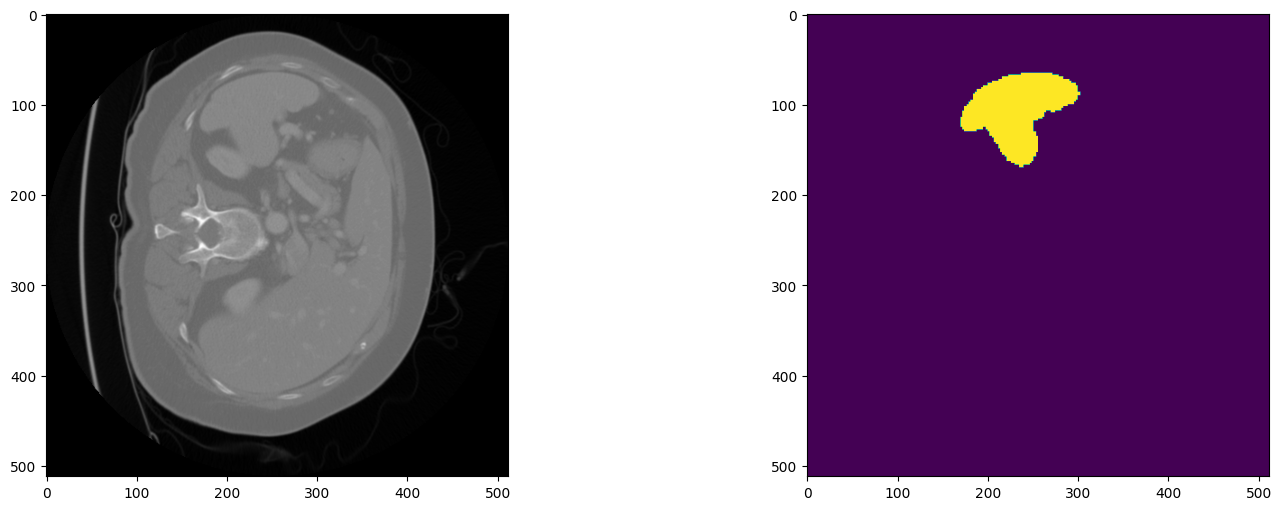

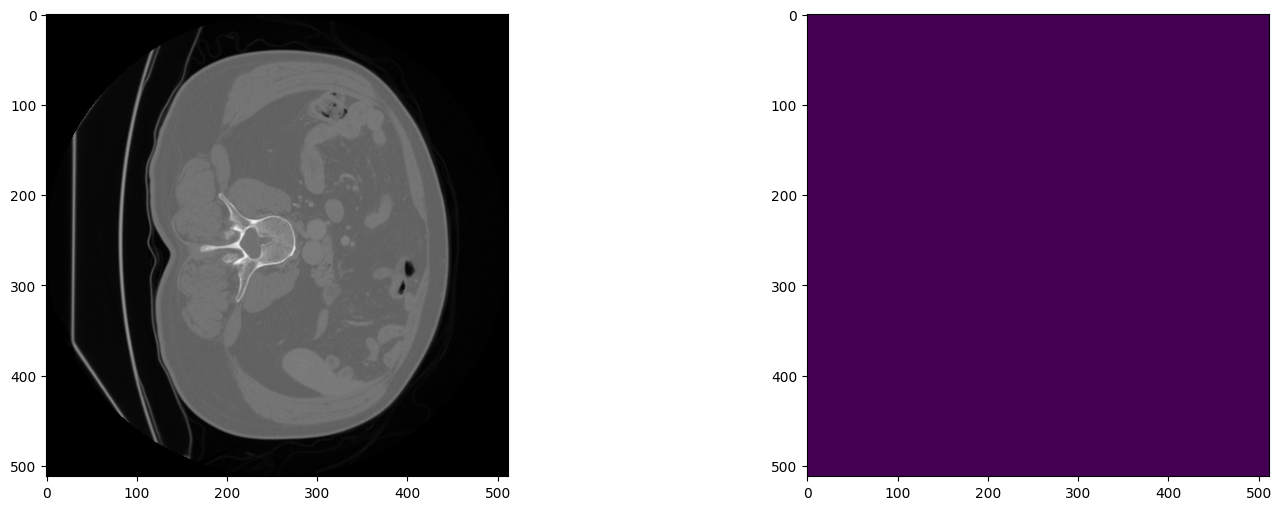

In [10]:
# Visualize the results of the fine-tuned model.
with torch.no_grad():
    test_outputs = vista3d_ft_pipeline(test_data, save_output=False)
    for test_output in test_outputs:
        original_image = loader(test_output[0]["image"].meta["filename_or_obj"])
        pred_output = convert_to_numpy(test_output[0]["pred"])

        plt.figure("check", (18, 6))
        plt.subplot(1, 2, 1)
        plt.imshow(original_image[:, :, 20], cmap="gray")
        plt.subplot(1, 2, 2)
        plt.imshow(pred_output[:, :, 20])
        plt.show()

## Limpiar el directorio de datos

Elimina el directorio si se utilizó uno temporal.

Como buena práctica, esta celda final limpia los archivos y directorios temporales creados durante la ejecución del cuaderno para evitar dejar datos innecesarios en el sistema.

In [11]:
if directory is None:
    shutil.rmtree(root_dir)